# USDA Plants clustering

## Problem description

The USDA Plants database provides standardized information about the vascular plants, mosses, liverworts, hornworts, and lichens of the U.S. and its territories. 

The dataset is composed of 34781 instances of plants names, associated with the states names where they can be found in. The dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/Plants) and is taken from -- _USDA, NRCS. 2008. The PLANTS Database (31 December 2008). National Plant Data Center, Baton Rouge, LA 70874-4490 USA._ --

The goal of this project will be to cluster the plants based on the regions where they are present; we are in an unsupervised learning scenario.

In [1]:
#Let's import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict

In [2]:
#Create 70 columns to store the states names later
names = []
for i in range(70):
    names.append(i)
names = list(names)    

In [3]:
#Load the dataset precising the number of columns so that it avoids creating the number of columns based on the first row
df = pd.read_csv('Plants/plants.data', names=names, encoding = "ISO-8859-1")

/Users/charlottewaltregny/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (69) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#We store the plants names in an array and we create a dataframe only containing the states information
plants = df[0]
states = df.loc[:,1:]

In [5]:
states.head()

,1,2,3,4,5,6,7,8,9,10,...,60,61,62,63,64,65,66,67,68,69
0,fl,nc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,fl,nc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ct,dc,fl,hi,il,ky,la,md,mi,ms,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ct,dc,fl,il,ky,la,md,mi,ms,nc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,hi,pr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data analysis and preparation

We see that we need to do some transformation in order to be able to retrieve information from this dataset. We see that a lot of plants are only present in a few states, and very few plants are present in the 69 states. Let's first create an array with the states names by looking at the hits where the 69th column is filled.

In [6]:
df[df[69].notnull()]

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
11724,eleocharis,al,ak,az,ar,ca,co,ct,de,dc,...,nt,ns,nu,on,pe,qc,sk,yt,dengl,fraspm
12372,erigeron,al,ak,az,ar,ca,co,ct,de,dc,...,nt,ns,nu,on,pe,qc,sk,yt,dengl,fraspm
25582,plantago,al,ak,az,ar,ca,co,ct,de,dc,...,nt,ns,nu,on,pe,qc,sk,yt,dengl,fraspm
26125,polygonum,al,ak,az,ar,ca,co,ct,de,dc,...,nt,ns,nu,on,pe,qc,sk,yt,dengl,fraspm


Indeed, we only have 4 plants presents in the 69 states. Let's retrieve the names of the states.

In [7]:
names = states.iloc[11724].values

In [8]:
names

array(['al', 'ak', 'az', 'ar', 'ca', 'co', 'ct', 'de', 'dc', 'fl', 'ga',
       'hi', 'id', 'il', 'in', 'ia', 'ks', 'ky', 'la', 'me', 'md', 'ma',
       'mi', 'mn', 'ms', 'mo', 'mt', 'ne', 'nv', 'nh', 'nj', 'nm', 'ny',
       'nc', 'nd', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx',
       'ut', 'vt', 'va', 'wa', 'wv', 'wi', 'wy', 'pr', 'vi', 'ab', 'bc',
       'lb', 'mb', 'nb', 'nf', 'nt', 'ns', 'nu', 'on', 'pe', 'qc', 'sk',
       'yt', 'dengl', 'fraspm'], dtype=object)

Now, how are we going to transform this dataset to be able to use it? One idea is to make the 69 columns the states names in the alphabetical order, go through each row and replace by 1s the cells where the plant is found in the states (corresponding column) and by 0s the cells where the plant is not. Let's do that.

In [9]:
#Store the indexes in the range 34781 in an array and each element of each row in another one
indexes = []
elements = []
for index,row in states.iterrows():
    indexes.append(index)
    elements.append([])
    for element in row.values:
        elements[index].append(element)

In [10]:
#Create a dictionary with the values corresponding to the column number
dic = {'al':0, 'ak':1, 'az':2, 'ar':3, 'ca':4, 'co':5, 'ct':6, 'de':7, 'dc':8, 'fl':9, 'ga':10,
       'hi':11, 'id':12, 'il':13, 'in':14, 'ia':15, 'ks':16, 'ky':17, 'la':18, 'me':19, 'md':20, 'ma':21,
       'mi':22, 'mn':23, 'ms':24, 'mo':25, 'mt':26, 'ne':27, 'nv':28, 'nh':29, 'nj':30, 'nm':31, 'ny':32,
       'nc':33, 'nd':34, 'oh':35, 'ok':36, 'or':37, 'pa':38, 'ri':39, 'sc':40, 'sd':41, 'tn':42, 'tx':43,
       'ut':44, 'vt':45, 'va':46, 'wa':47, 'wv':48, 'wi':49, 'wy':50, 'pr':51, 'vi':52, 'ab':53, 'bc':54,
       'lb':55, 'mb':56, 'nb':57, 'nf':58, 'nt':59, 'ns':60, 'nu':61, 'on':62, 'pe':63, 'qc':64, 'sk':65,
       'yt':66, 'dengl':67, 'fraspm':68}

In [11]:
#Check which index are going to be filled with 1
value_index = []
for index in indexes:
    value_index.append([])
    for element in elements[index]:
        if element in names:
            value_index[index].append(dic[element])

In [12]:
#Fill everything with 0 and replace by 1 where value_index indicates it
ones_zeros={}
for index in indexes:
    for i in range(69):
        ones_zeros[index,i]=0
for index in indexes:
    for val in value_index[index]:
            ones_zeros[index,val]=1    

In [13]:
#Transform the list to an array to make it usable
X_list=[]
for (key1,key2),value in ones_zeros.items():
    temp = [key1,value]
    X_list.append([])
    X_list[key1].append(value)

In [14]:
#Transform it to a dataframe to clean it more easily
df_list=pd.DataFrame(X_list)
#Necessary, because when transforming to a list, a lot of unnecessary fields where created
df_list = df_list.dropna(how='all')

Did it create what we wanted? Let's check the first row.  

In [15]:
states.head(1)

,1,2,3,4,5,6,7,8,9,10,...,60,61,62,63,64,65,66,67,68,69
0,fl,nc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
print('Position of the elements to fill with 1: ', dic['fl'],',', dic['nc'])

Position of the elements to fill with 1:  9 , 33


We are supposed to have '1' at position 9 in our array (corresponding to 'fl'), then '1' at position 33 (corresponding to 'nc') then only '0' for all the other columns.  

In [17]:
df_list.head(1)

,0,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,64,65,66,67,68
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
df_list.loc[:,:35].head(1)

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Great! This is what we needed. We look at different others randomly picked rows for checking and it confirms that it gives us what we needed to move on to the clustering part.

## Modelling and evaluation

We are ready to start clustering our data. We first create the training array that will be used for the modelling.

In [19]:
X = df_list.values

In [20]:
y = plants

Now let's see to what our data look like! We take the 2 first principal components to plot the 2D projection of our data.

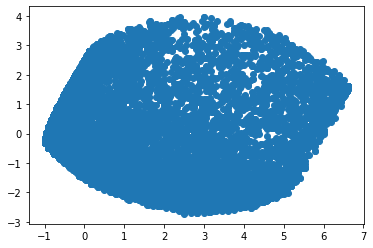

In [21]:
x = PCA(n_components=2).fit_transform(X)
plt.scatter(x[:,0], x[:,1])

Ok we see, at least **in 2D**, that we have **no visible separation in different groups**, rather we have one big blob with all of our data. But these **groups might be present in the other dimensions** (remember we have 68 of them). We will use first KMeans algorithm to cluster our data, as the results of this algorithm are easily interpretable. But before clustering using KMeans, we need to have an idea of the number of clusters we will group our data into. To do so, we will use the **Elbow method**, which consists of plotting the sum of the squared distance between each member of the cluster and its centroid (WCSS) against the number of clusters. This graph will help us to select the number of clusters where the change in WCSS begins to level off.

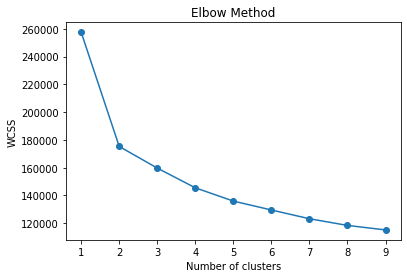

In [22]:
from sklearn.cluster import KMeans
#code taken from https://towardsdatascience.com/machine-learning-algorithms-part-9-k-means-example-in-python-f2ad05ed5203
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 10), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Here 6 seems to be a good number of clusters so let's try this value and visualize the result in 2D.

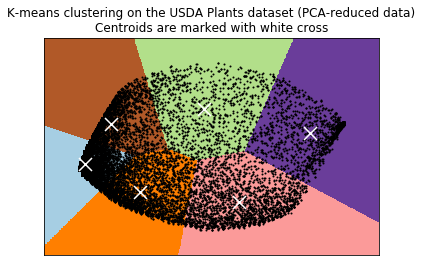

In [23]:
reduced_data = PCA(n_components=2).fit_transform(X)
kmeans = KMeans(init='k-means++', n_clusters=6, n_init=10)
kmeans.fit(reduced_data)
#Code taken from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the USDA Plants dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

From this, we can't really know if we made the right choice in terms of algorithm and number of clusters. Besides, we used PCA-reduced data, let's see how much of the variance is preserved with 2 principal components.

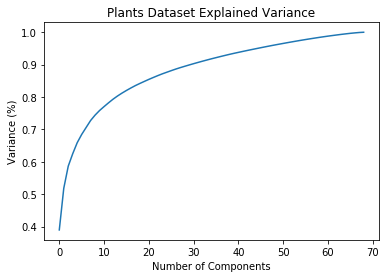

In [24]:
#Assuming the data are normalized as stated in the dataset description, we apply PCA.
pca = PCA().fit(X)
#Plotting the Cumulative Summation of the Explained Variance
#Idea taken from 'https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe'
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Plants Dataset Explained Variance')
plt.show()

In [25]:
pca=PCA(n_components=2).fit(X)
print(sum(pca.explained_variance_ratio_))

0.5184059703435955


Only 51% of the total variance is preserved. 2 components is really good for visualizing, but a terrible choice for fitting our algorithm to the transformed data given it does not represent our dataset. 

Let's get back to the problem; we want to cluster plants based on the regions they are found in. A good choice of algorithm could be a **hierarchical agglomerative one**, starting with every data being a cluster then grouping them progressively until we group all of them. Let's plot the dendrogram to assess the number of clusters we should use for this method. The number of lines in the largest vertical distance is the number of clusters we should use. 

Here we use the **Ward** linkage to compute the distance, which is the sum of squared differences within all clusters.

In [26]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

In [27]:
#We take a subset for the visualization parts
sample = X[:10000]

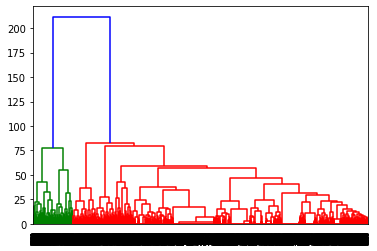

In [28]:
#Will take a while to run
dendrogram = sch.dendrogram(sch.linkage(sample, method='ward'))

We see that 2 clusters seem to be the good choice. We apply the algorithm based on this choice and visualize the result in 3D to see if we can get more information than the one provided by the 2D representation.

In [29]:
#Fit the model on the subset for visualization purpose
agg = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
agg.fit(sample)
labels = agg.labels_

In [30]:
#Prepare function to plot our model in 3D on the subset of the data
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
from matplotlib import animation
def prepare_tsne(n_components, data, model_labels):
    names = ['x', 'y', 'z']
    matrix = TSNE(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = model_labels
    
    return df_matrix
    
def plot_animation(df, label_column, name):
    def update(num):
        ax.view_init(200, num)

    N=360
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(tsne_3d_df['x'], tsne_3d_df['y'], tsne_3d_df['z'], c=tsne_3d_df[label_column],
               s=6, depthshade=True, cmap='Paired')
    ax.set_zlim(-15, 25)
    ax.set_xlim(-20, 20)
    plt.tight_layout()
    ani = animation.FuncAnimation(fig, update, N, blit=False, interval=50)
    ani.save('{}.gif'.format(name), writer='imagemagick')
    plt.show()

In [31]:
#Will take a while to run, we create the 3D dataframe projection of our data
#Not necessary to run it, as the gif is already created and provided below
tsne_3d_df = prepare_tsne(3, sample, agg.labels_)

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


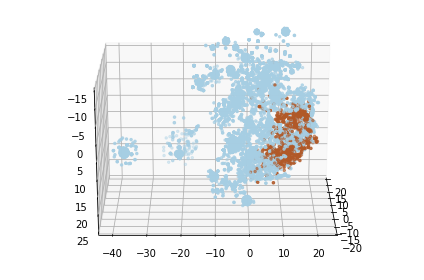

In [32]:
plot_animation(tsne_3d_df, 'labels', 'labels_agg')

The gif can be found at https://github.com/cwaltregny/USDA_Plants/blob/master/labels_agg.gif. This plot is interesting because we can see that **groups of data are actually present** and can be seen in 3D, which could not be in 2D. Let's apply both our algorithms on the whole data, and not reduced, set and evaluate the models using the **silhouette method**. We don't have ground truth data so this is the metrics we will use **to quantify the quality of clustering achieved**.

In [33]:
kmeans = KMeans(n_clusters=6, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [35]:
#Will take a while to run
agg = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
agg.fit(X)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=2,
                        pooling_func='deprecated')

In [36]:
from sklearn import metrics
agg_silhouette = metrics.silhouette_score(X, agg.labels_,
                                      metric='euclidean',
                                      sample_size=len(X))
kmeans_silhouette = metrics.silhouette_score(X, kmeans.labels_,
                                      metric='euclidean',
                                      sample_size=len(X))
print('Agglomerative: ', agg_silhouette)
print('KMeans: ', kmeans_silhouette)

Agglomerative:  0.4310639117713727
KMeans:  0.3329868384289614


We see that the silhouette score for KMeans is really low. Maybe our choice of number of clusters was wrong; let's plot the evolution of the silhouette score against the number of clusters used.

In [37]:
#Will take a while to run
store_score = []
for i in range(2,10):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    store_score.append(metrics.silhouette_score(X, kmeans.labels_,
                                      metric='euclidean',
                                      sample_size=len(X)))   

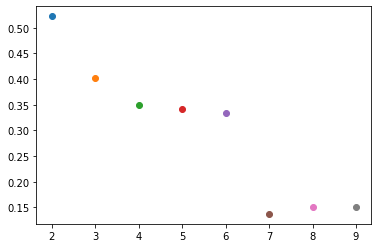

In [38]:
for i in range(8):
    plt.plot(i+2,store_score[i], linestyle='-', marker='o')

We see that **2 clusters was actually a much better choice!** Looking back, it is not suprising as it is really where the elbow occurs (see Elbow method plot above). Let's choose this number for the KMeans algorithm and visualize the result in 3D. The gif can be found at https://github.com/cwaltregny/USDA_Plants/blob/master/labels_kmeans.gif (as the computation takes time, we won't do it in the workflow but the code is left at the end of the notebook if necessary). Let's look at the updated silouhette scores. 

In [39]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(X)
kmeans_silhouette = metrics.silhouette_score(X, kmeans.labels_,
                                      metric='euclidean',
                                      sample_size=len(X))

In [40]:
print('Agglomerative: ', agg_silhouette)
print('KMeans: ', kmeans_silhouette)

Agglomerative:  0.4310639117713727
KMeans:  0.5223190004289854


## Conclusion

The goal of this model was to cluster plants based on the North American states they can be found in. We tried 2 algorithms with the optimal number of clusters found; in this case, 2. KMeans seems better at separating our data. Now, what does these 2 clusters actually mean? What do they represent?

In [41]:
#We create a dataframe for the interpretation and we add the labels assigned by the kmeans algorithm
df_interpret = pd.DataFrame(X)
df_interpret['label'] = kmeans.labels_

In [42]:
#We group our data by the 2 clusters and we take the mean for each variable
df_mean=df_interpret.groupby('label').mean()
df_mean

,0,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,64,65,66,67,68
label,,,,,,,,,,,,,,,,,,,,,
0,0.671560,0.243708,0.343960,0.661913,0.432257,0.409396,0.788591,0.667156,0.586200,0.507550,...,0.203859,0.495176,0.083473,0.780831,0.345847,0.634648,0.377936,0.192114,0.082215,0.214346
1,0.083297,0.060207,0.171192,0.048446,0.320361,0.117049,0.021024,0.014960,0.009496,0.139973,...,0.035051,0.016093,0.019358,0.044814,0.006397,0.041515,0.034785,0.039450,0.002899,0.006264


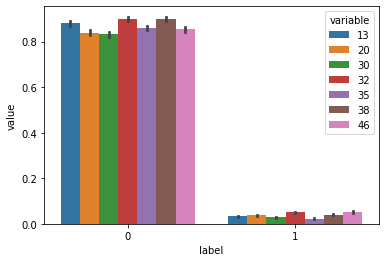

In [43]:
#We create a new dataframe which will store the states number in the column ' Variable' and the corresponding mean in 'Var'
#We take the first 7 values of highest mean to see the importance of the features in the clustering algorithm
results = pd.DataFrame(columns=['Variable', 'Var'])
for column in df_mean.columns[1:]:
    results.loc[len(results), :] = [column, np.var(df_mean[column])]
selected_columns = list(results.sort_values(
        'Var', ascending=False,
    ).head(7).Variable.values) + ['label']
tidy = df_interpret[selected_columns].melt(id_vars='label')
sns.barplot(x='label', y='value', hue='variable', data=tidy)

In [44]:
values = list(results.sort_values(
        'Var', ascending=False,
    ).head(7).Variable.values)
for i in values:
    print(list(dic.keys())[list(dic.values()).index(i)])

pa
ny
il
oh
nj
va
md


Meaning Pennsylvania, New York, Illinois, Ohio, New Jersey, Virginia and Maryland were clustered together in cluster 0. It does make sense, by looking at a map of the US, we see that all these states are close from each other. **Without any knowledge of the distance between the states, our algorithm could deduce it based on the plants location!** Similar plants tend to be found in similar territories which makes sense as well.

### [Additional code for KMeans 3D visualization]

In [38]:
#On subset for visualization purposes 
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(sample)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [39]:
tsne_3d_df_kmeans = prepare_tsne(3, sample, kmeans.labels_)

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


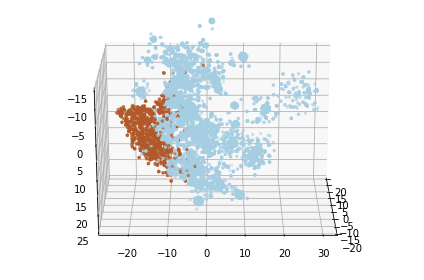

In [40]:
plot_animation(tsne_3d_df_kmeans, 'labels', 'labels_kmeans')